In [2]:
import numpy as np
from sklearn.metrics import precision_score, confusion_matrix, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from math import floor
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
list_stop_words = stopwords.words('english')
list_stop_words.append("im")
stopwords1 = set(STOPWORDS)
stopwords1.update(["br", "href","https","t","co","c","b'RT","b'","'","neg","b","neg'", "I m", "I d", "i tt", "ift"])

In [25]:
import pandas as pd
df = pd.read_csv(r'twitter_training.csv')
df.columns = ['id', 'topic', 'polarity', 'tweet']
df = df.dropna()

In [26]:
df.head()


,id,topic,polarity,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [27]:
df.shape                 

(73995, 4)

<body>selecting the data based on the topic as the data is too large</body>

In [28]:
df = df.loc[df['topic'].isin(['Amazon', 'Facebook', 'Xbox(Xseries)','Nvidia','Google','Microsoft', 'FIFA', 'HomeDepot'])]#.groupby('topic').count()
df.shape

(18443, 4)

In [29]:
#function to clean the data
def process_tweet(tweet):
    char = ''
    arr = []
    empty_words = ['',' ', '  ']
    
    for word in str(tweet).replace(",", " ").split():
        #print(word)
        if(word.lower().strip() in ['amazon','facebook','nvidia','google','microsoft']):
            continue
        if len(word) == 1:
            continue
        word = re.sub(r'^RT[\s]','', word)
        word = re.sub(r'https?:\/\/.*[\r\n]*','', word)
        word = re.sub(r'\s+','', word)
        if(re.search('^@[\s]?[a-zA-Z0-9]',word)):
            continue
        if(re.search('^@[\s]+[a-zA-Z0-9]',word)):
            #print(word)
            continue 
        if(re.search('\W',word)):
            word = re.sub(r'\W','',word)
        if(re.search('pi.*om',word)):
            continue
        if(re.search(r'\d',word)):
            continue
        if (re.search(r'\ ',word)):
            continue
        if word.strip().lower() not in list_stop_words and word not in string.punctuation and word not in empty_words and word not in stopwords1:
            arr.append(word.strip())
    return " ".join(arr)

In [30]:
#label encoding
new_col = []
for t in df['tweet']:
    new_col.append(process_tweet(t))
    
df['unique_words'] = new_col
df = df[df['polarity'].isin(['Positive','Negative'])]

temp = [] 
for i in df['polarity']:
    if i == 'Positive':
        temp.append(1)
    else:
        temp.append(0)

df['Sentiment'] = temp

In [31]:
df.head()

,id,topic,polarity,tweet,unique_words,Sentiment
4661,1,Amazon,Negative,@amazon wtf .,wtf,0
4662,1,Amazon,Negative,@ amazon wtf.,wtf,0
4663,1,Amazon,Negative,@ amazon wtf.,wtf,0
4664,1,Amazon,Negative,@amazon wtf?,wtf,0
4665,1,Amazon,Negative,7 @amazon wtf.,wtf,0


In [32]:
#fetching the rare words from the tweets and getting the words that are occured only once 
rare_words = pd.Series(" ".join(df["unique_words"]).split()).value_counts()
rare_words = rare_words[rare_words <= 2]

In [33]:
#removing the words that occured only once
df["unique_words"] = df["unique_words"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))

#getting the features and labels
X = df['unique_words']
y = df['Sentiment']

In [34]:
X.shape

(9894,)

In [11]:
#splitting and converting the data into numerical fearures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)
vectorizer = TfidfVectorizer(min_df = 7)
X_vector_train = vectorizer.fit_transform(X_train)
X_vector_valid = vectorizer.transform(X_valid)
X_vector_train.shape

(7915, 2020)

In [12]:
#converting the data into array and adding bias
x_train_df = X_vector_train.toarray()
x_valid_df = X_vector_valid.toarray()

x_train_df_new = np.insert(x_train_df, 0, 1, axis = 1)
x_valid_df_new = np.insert(x_valid_df, 0, 1, axis = 1)

x_train_df = x_train_df_new
x_valid_df = x_valid_df_new
x_train_df.shape

(7915, 2021)

In [13]:
#converting the labels into arrays
y_train_df = pd.Series(y_train).array
y_valid_df = pd.Series(y_valid).array

<h3> Perceptron </h3>

<body> function to train the perceptron </body>

In [14]:
def perceptron(x, y, w, eta = 0.1, n = 1):
    
    k = 0
    for it in range(n):
        for ind, ex in enumerate(x):
            prod = np.dot(ex, w)

            if prod > 0:
                pred = 1
            else:
                pred = 0

            true_label = y[ind]
            if true_label != pred:
                k+=1
                for i in range(len(w)):

                    w[i] += eta * (true_label - pred )*ex[i]
                
    return w    

<body> training the perceptron on train data and checking the accuracy on validation data</body>

In [15]:
n = [1, 3, 5, 7, 10, 20,30, 50]
eta = [0.01, 0.05, 0.1, 0.5, 0.9]
precision_score_mat = {}
confusion_matrix_mat = {}
for i_n in n:
    for j in eta:
        W = np.zeros((x_train_df.shape[1], 1))
        W = perceptron(x_train_df, y_train_df, W, j, i_n)
        
        pred_valid_y = []
        for i in range(len(x_valid_df)):
            val = np.dot(x_valid_df[i], W)

            if val > 0:
                pred_valid_y.append(1)
            else:
                pred_valid_y.append(0)
        p_s = accuracy_score(y_valid_df,pred_valid_y)
        C_m = confusion_matrix(y_valid_df,pred_valid_y)
        print(f"the accuracy score whene eta = {j} and n = {i_n} is {p_s}")
        precision_score_mat[str(i_n), str(j)] = p_s
        print(f"the confusion matrix whene eta = {j} and n = {i_n} is {C_m}")
        confusion_matrix_mat[str(i_n), str(j)] = C_m

the accuracy score whene eta = 0.01 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.01 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.05 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.05 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.1 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.1 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.5 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.5 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.9 and n = 1 is 0.8514401212733704
the confusion matrix whene eta = 0.9 and n = 1 is [[971 112]
 [182 714]]
the accuracy score whene eta = 0.01 and n = 3 is 0.8807478524507327
the confusion matrix whene eta = 0.01 and n = 3 is [[1015   68]
 [ 168  728]]
the accuracy score whene eta = 0.05 and n = 3 is 0.8807478524507327
the confusion matrix whene eta = 0.05 and n = 3 is [[1015   68]
 [ 168  728]]
the 

In [16]:
x_train_df.shape

(7915, 2021)

In [17]:
iter_num = []
prec = []
for i in precision_score_mat.keys():
    if i[1] == '0.1':
        iter_num.append(i[0])
        prec.append(precision_score_mat[i])
        print(i, precision_score_mat[i])

('1', '0.1') 0.8514401212733704
('3', '0.1') 0.8807478524507327
('5', '0.1') 0.8807478524507327
('7', '0.1') 0.8817584638706417
('10', '0.1') 0.8913592723597776
('20', '0.1') 0.8888327438100051
('30', '0.1') 0.8888327438100051
('50', '0.1') 0.8832743810005053


Text(0.5, 1.0, 'Accuracy score for different number of iteration for learning rate = 0.1 for perceptron')

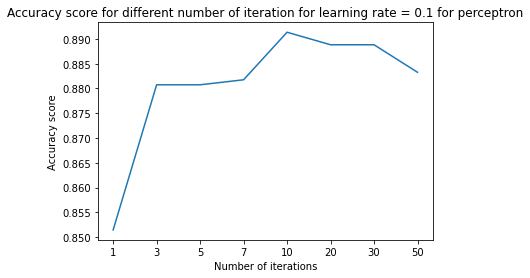

In [18]:
plt.plot(iter_num, prec)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy score")
plt.title("Accuracy score for different number of iteration for learning rate = 0.1 for perceptron")

<h3> Logistic Regression </h3>

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def calc_h(X, theta):
    z = np.dot(X, theta)
    h = sigmoid(z)
    return h

<body> function to create a logistic regression model </body>

In [20]:
def logistic_regression(X_inp, y, num_iter = 100, alpha = 0.1, lambda_value = 0.0000001):
    cost_epochs = []
    theta = np.zeros(X_inp.shape[1])
    m = y.size
    batchsize = 100
    batches = floor(y.size/batchsize)
    #lambda_value = 0.0000001
    for epoch in range(num_iter):
        cost_list = []
        for i in range(batches):
            s = i*batchsize
            k= s+ batchsize
            Y = y[s:k]
            x = X_inp[s:k,:]
            h = calc_h(x, theta)
            lasso_reg_term = (lambda_value / 2 * batchsize) * sum(abs(theta))
            cost = (-Y * np.log(h) - (1 - Y) * np.log(1 - h)).mean() + lasso_reg_term
            cost_list.append(cost)

            gradient = (np.dot(x.T, (h - Y)))/ batchsize  +  (lambda_value * abs(theta))
            theta -= alpha * gradient

        cost_epochs.append(np.average(cost_list))
        if((epoch + 1 )%10 ==0):    
            print(f"After {epoch+1} epochs, Loss = {cost}")
            

    #print('Adjusted coefficient: {}'.format(theta))
    print(h.shape)
    return theta, cost_epochs

<body> training the logistic regression on various number of iterations </body>

In [21]:
valid_accuracy = []
ite = [20, 200, 2000, 4000, 10000]
lambda_val = [0.0000001, 0.00001, 0.001, 1, 3, 5, 5000]
for i in ite:
    theta, cost_epochs = logistic_regression(x_train_df, y_train_df, i, alpha = 0.1)
    preds_prob = calc_h(x_valid_df, theta)
    y_pred = preds_prob.round()
    valid_accuracy.append(accuracy_score(y_valid_df,y_pred))

After 10 epochs, Loss = 0.680182591932619
After 20 epochs, Loss = 0.6518196287515539
(100,)
After 10 epochs, Loss = 0.680182591932619
After 20 epochs, Loss = 0.6518196287515539
After 30 epochs, Loss = 0.6273704927241284
After 40 epochs, Loss = 0.6060520462298619
After 50 epochs, Loss = 0.5872623826938489
After 60 epochs, Loss = 0.5705390119711659
After 70 epochs, Loss = 0.5555243016437804
After 80 epochs, Loss = 0.541938969521321
After 90 epochs, Loss = 0.5295623777279276
After 100 epochs, Loss = 0.5182182626637097
After 110 epochs, Loss = 0.507764129655649
After 120 epochs, Loss = 0.49808356396380865
After 130 epochs, Loss = 0.48908047928854376
After 140 epochs, Loss = 0.48067485649211517
After 150 epochs, Loss = 0.4727993952767928
After 160 epochs, Loss = 0.46539712848006637
After 170 epochs, Loss = 0.4584194547076961
After 180 epochs, Loss = 0.4518245374309676
After 190 epochs, Loss = 0.44557625942946033
After 200 epochs, Loss = 0.43964320515692423
(100,)
After 10 epochs, Loss = 0.6

After 1630 epochs, Loss = 0.22721332262961583
After 1640 epochs, Loss = 0.2267567729184535
After 1650 epochs, Loss = 0.22630413405588237
After 1660 epochs, Loss = 0.225855355079352
After 1670 epochs, Loss = 0.225410384529583
After 1680 epochs, Loss = 0.22496915762947753
After 1690 epochs, Loss = 0.2245316191770779
After 1700 epochs, Loss = 0.22409771812819682
After 1710 epochs, Loss = 0.22366740471822008
After 1720 epochs, Loss = 0.2232406301297969
After 1730 epochs, Loss = 0.22281735649303758
After 1740 epochs, Loss = 0.2223975292496948
After 1750 epochs, Loss = 0.2219810998312391
After 1760 epochs, Loss = 0.22156802298765377
After 1770 epochs, Loss = 0.22115825430845118
After 1780 epochs, Loss = 0.22075175020293214
After 1790 epochs, Loss = 0.22034846788100204
After 1800 epochs, Loss = 0.21994836533452572
After 1810 epochs, Loss = 0.21955140220031294
After 1820 epochs, Loss = 0.219157543643049
After 1830 epochs, Loss = 0.21876674654623188
After 1840 epochs, Loss = 0.2183789774679938


After 1460 epochs, Loss = 0.23563146492178824
After 1470 epochs, Loss = 0.23509889152671087
After 1480 epochs, Loss = 0.2345713716681381
After 1490 epochs, Loss = 0.2340488322924961
After 1500 epochs, Loss = 0.2335311664537416
After 1510 epochs, Loss = 0.23301829939979096
After 1520 epochs, Loss = 0.23251015796422553
After 1530 epochs, Loss = 0.23200667073448833
After 1540 epochs, Loss = 0.23150777961520386
After 1550 epochs, Loss = 0.2310134037553895
After 1560 epochs, Loss = 0.23052347774849685
After 1570 epochs, Loss = 0.2300379509373657
After 1580 epochs, Loss = 0.22955674184377362
After 1590 epochs, Loss = 0.22907978728454995
After 1600 epochs, Loss = 0.22860702535840813
After 1610 epochs, Loss = 0.22813839541311404
After 1620 epochs, Loss = 0.22767384329744772
After 1630 epochs, Loss = 0.22721332262961583
After 1640 epochs, Loss = 0.2267567729184535
After 1650 epochs, Loss = 0.22630413405588237
After 1660 epochs, Loss = 0.225855355079352
After 1670 epochs, Loss = 0.22541038452958

After 3260 epochs, Loss = 0.18248646769180688
After 3270 epochs, Loss = 0.18231906320857016
After 3280 epochs, Loss = 0.18215242332817533
After 3290 epochs, Loss = 0.1819865626602788
After 3300 epochs, Loss = 0.18182147539769766
After 3310 epochs, Loss = 0.18165713688631704
After 3320 epochs, Loss = 0.1814935375530389
After 3330 epochs, Loss = 0.1813306720522628
After 3340 epochs, Loss = 0.18116854432186374
After 3350 epochs, Loss = 0.18100714379503507
After 3360 epochs, Loss = 0.18084646142737842
After 3370 epochs, Loss = 0.18068649208317114
After 3380 epochs, Loss = 0.18052723226710626
After 3390 epochs, Loss = 0.1803686861890996
After 3400 epochs, Loss = 0.1802108380589592
After 3410 epochs, Loss = 0.18005369039352173
After 3420 epochs, Loss = 0.17989725072709037
After 3430 epochs, Loss = 0.17974149424721744
After 3440 epochs, Loss = 0.179586416161586
After 3450 epochs, Loss = 0.17943201172441905
After 3460 epochs, Loss = 0.17927827623587597
After 3470 epochs, Loss = 0.1791252050414

After 1090 epochs, Loss = 0.2597863197678567
After 1100 epochs, Loss = 0.25899154754590614
After 1110 epochs, Loss = 0.25820652019270285
After 1120 epochs, Loss = 0.257431014398731
After 1130 epochs, Loss = 0.2566648359440346
After 1140 epochs, Loss = 0.25590779831242183
After 1150 epochs, Loss = 0.2551597323050544
After 1160 epochs, Loss = 0.2544204622748235
After 1170 epochs, Loss = 0.25368981275261326
After 1180 epochs, Loss = 0.252967618335195
After 1190 epochs, Loss = 0.25225373464729006
After 1200 epochs, Loss = 0.25154805526187163
After 1210 epochs, Loss = 0.2508503620961792
After 1220 epochs, Loss = 0.25016050730560146
After 1230 epochs, Loss = 0.24947834679972208
After 1240 epochs, Loss = 0.24880374249517723
After 1250 epochs, Loss = 0.24813655645402113
After 1260 epochs, Loss = 0.2474767189003882
After 1270 epochs, Loss = 0.2468240793432228
After 1280 epochs, Loss = 0.24617847715772678
After 1290 epochs, Loss = 0.24553977739077676
After 1300 epochs, Loss = 0.24490785898172582

After 2890 epochs, Loss = 0.18927545978091548
After 2900 epochs, Loss = 0.18907518404071394
After 2910 epochs, Loss = 0.188875923174233
After 2920 epochs, Loss = 0.18867766887136758
After 2930 epochs, Loss = 0.18848046148185743
After 2940 epochs, Loss = 0.1882842510017224
After 2950 epochs, Loss = 0.18808902274303524
After 2960 epochs, Loss = 0.1878947687669956
After 2970 epochs, Loss = 0.18770148271649173
After 2980 epochs, Loss = 0.18750918616915332
After 2990 epochs, Loss = 0.18731784543864705
After 3000 epochs, Loss = 0.18712744817221272
After 3010 epochs, Loss = 0.1869379868650374
After 3020 epochs, Loss = 0.18674946571692588
After 3030 epochs, Loss = 0.18656186624183188
After 3040 epochs, Loss = 0.18637518610424955
After 3050 epochs, Loss = 0.18618942649313458
After 3060 epochs, Loss = 0.18600457878219417
After 3070 epochs, Loss = 0.1858206237186083
After 3080 epochs, Loss = 0.18563755435467932
After 3090 epochs, Loss = 0.18545536381798108
After 3100 epochs, Loss = 0.185274045310

After 4690 epochs, Loss = 0.16433293872217442
After 4700 epochs, Loss = 0.16423654209808541
After 4710 epochs, Loss = 0.1641404598086837
After 4720 epochs, Loss = 0.16404469020273274
After 4730 epochs, Loss = 0.1639492316407887
After 4740 epochs, Loss = 0.16385408249509373
After 4750 epochs, Loss = 0.1637592411494695
After 4760 epochs, Loss = 0.16366471098985905
After 4770 epochs, Loss = 0.16357049432343077
After 4780 epochs, Loss = 0.163476586501227
After 4790 epochs, Loss = 0.1633829822659185
After 4800 epochs, Loss = 0.1632896780823869
After 4810 epochs, Loss = 0.16319667440487723
After 4820 epochs, Loss = 0.1631039706119767
After 4830 epochs, Loss = 0.16301156205892403
After 4840 epochs, Loss = 0.16291944722917673
After 4850 epochs, Loss = 0.16282762461677014
After 4860 epochs, Loss = 0.16273609272622866
After 4870 epochs, Loss = 0.16264485007247292
After 4880 epochs, Loss = 0.16255389518072624
After 4890 epochs, Loss = 0.16246322658642287
After 4900 epochs, Loss = 0.16237284283511

After 6490 epochs, Loss = 0.15085640674096476
After 6500 epochs, Loss = 0.15079815728881438
After 6510 epochs, Loss = 0.1507400466772938
After 6520 epochs, Loss = 0.15068207436148556
After 6530 epochs, Loss = 0.15062423979937925
After 6540 epochs, Loss = 0.15056654245185394
After 6550 epochs, Loss = 0.15050898178265784
After 6560 epochs, Loss = 0.1504515572583901
After 6570 epochs, Loss = 0.15039426834848058
After 6580 epochs, Loss = 0.1503371145251725
After 6590 epochs, Loss = 0.15028009526350294
After 6600 epochs, Loss = 0.1502232100412851
After 6610 epochs, Loss = 0.15016645833908895
After 6620 epochs, Loss = 0.15010983964022417
After 6630 epochs, Loss = 0.15005335343072151
After 6640 epochs, Loss = 0.1499969991993149
After 6650 epochs, Loss = 0.14994077643742404
After 6660 epochs, Loss = 0.1498846846391363
After 6670 epochs, Loss = 0.14982872330118985
After 6680 epochs, Loss = 0.14977289192295568
After 6690 epochs, Loss = 0.14971719000642142
After 6700 epochs, Loss = 0.149661617056

After 8290 epochs, Loss = 0.14219441227757976
After 8300 epochs, Loss = 0.14215459884463327
After 8310 epochs, Loss = 0.14211485943140958
After 8320 epochs, Loss = 0.14207519380836184
After 8330 epochs, Loss = 0.14203560174693522
After 8340 epochs, Loss = 0.14199608301956107
After 8350 epochs, Loss = 0.14195663973912137
After 8360 epochs, Loss = 0.14191727383676064
After 8370 epochs, Loss = 0.14187798058983608
After 8380 epochs, Loss = 0.14183875977465749
After 8390 epochs, Loss = 0.14179961116849615
After 8400 epochs, Loss = 0.14176053454958032
After 8410 epochs, Loss = 0.14172152969708862
After 8420 epochs, Loss = 0.1416826024036947
After 8430 epochs, Loss = 0.14164375389988465
After 8440 epochs, Loss = 0.14160497649768988
After 8450 epochs, Loss = 0.1415662699800435
After 8460 epochs, Loss = 0.141527634130809
After 8470 epochs, Loss = 0.1414890687347704
After 8480 epochs, Loss = 0.14145057357762714
After 8490 epochs, Loss = 0.14141214844599004
After 8500 epochs, Loss = 0.14137379312

Text(0.5, 1.0, 'Accuracy score for logistic regression for learning rate = 0.1')

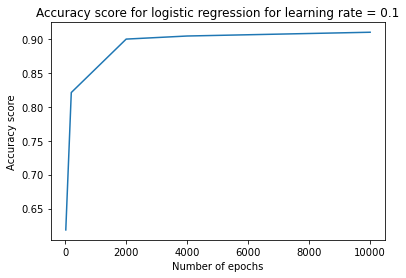

In [22]:
plt.plot(ite, valid_accuracy)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy score")
plt.title("Accuracy score for logistic regression for learning rate = 0.1")

<h3> Neural Networks </h3>

<body> class that creates and trains a neural network model </body>

In [20]:
import random
import numpy as np
 
# helpers
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))
 
def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))
 
class Neural_Network:
    # sizes is a list of the number of nodes in each layer
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.accuracy_mat = []
        
        #creating weights and bias
        self.bias = []
        self.weights = []
        for layer in range(len(sizes)):
            if layer != 0:
                self.bias.append(np.random.randn(sizes[layer], 1))
                
                inp_layer = sizes[layer-1]
                self.weights.append(np.random.randn(sizes[layer], inp_layer))
    
    def forwardPropagation(self, a):
        for b, w in zip(self.bias, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
   
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        training_data = list(training_data)
        samples = len(training_data)
       
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
       
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size]
                            for k in range(0, samples, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                #print(f"Epoch {j}: {self.evaluate(test_data)} / {n_test}")
                accuracy = self.evaluate(test_data)
                self.accuracy_mat.append(accuracy)
                print(f"Epoch {j}: {accuracy}")
            else:
                print(f"Epoch {j} complete")
   
    def cost_derivative(self, output_activations, y):
        return(output_activations - y)
   
    def backpropagation(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # forwardPropagation
        activation = x
        activations = [x] # stores activations layer by layer
        zs = [] # stores z vectors layer by layer
        for b, w in zip(self.bias, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
       
       
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_derivative(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
       
        for _layer in range(2, self.num_layers):
            z = zs[-_layer]
            sp = sigmoid_derivative(z)
            delta = np.dot(self.weights[-_layer+1].transpose(), delta) * sp
            nabla_b[-_layer] = delta
            nabla_w[-_layer] = np.dot(delta, activations[-_layer-1].transpose())
        return (nabla_b, nabla_w)
   
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.bias = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.bias, nabla_b)]
       
    def evaluate(self, test_data):
        pred = []
        true_label = []
        for (x, y) in test_data:
            #print(x, y)
            if y[0] == 1:
                true_label.append(0)
            else:
                true_label.append(1)
                
            pred.append(np.argmax(self.forwardPropagation(x)))
        return accuracy_score(true_label, pred)
    
    def predict(self, data):
        prediction = [np.argmax(self.forwardPropagation(x)) for (x, y) in data]
        return prediction

<body> function for doing one hot encoding. This is typically used on labels as the perceptron has two output neurons.</body>

In [21]:
def one_hot_encode(y):
    encoded = np.zeros((2, 1))
    encoded[y] = 1.0
    return encoded

<body> doing the one hot encoding on the labels. </body>

In [22]:
x_train_df = X_vector_train.toarray()
x_valid_df = X_vector_valid.toarray()
y_train_df = np.array(y_train)
y_valid_df = np.array(y_valid)

x_train_df = [np.reshape(x, (X_vector_train.shape[1], 1)) for x in x_train_df]
y_train_df = [one_hot_encode(y) for y in y_train_df]

x_valid_df = [np.reshape(x, (X_vector_train.shape[1], 1)) for x in x_valid_df]
y_valid_df = [one_hot_encode(y) for y in y_valid_df]

training_data = zip(x_train_df,y_train_df)
valid_data = zip(x_valid_df,y_valid_df)

<body> creating and training the networkk. </body>

In [23]:
net = Neural_Network([X_vector_train.shape[1], 100, 25, 2])
net.SGD(training_data, 500, 200, 0.5, test_data=valid_data)

Epoch 0: 0.5522991409802931
Epoch 1: 0.5694795351187468
Epoch 2: 0.5750378979282466
Epoch 3: 0.5775644264780192
Epoch 4: 0.584133400707428
Epoch 5: 0.5811015664477008
Epoch 6: 0.5811015664477008
Epoch 7: 0.5917129863567459
Epoch 8: 0.5932289034866094
Epoch 9: 0.5886811520970187
Epoch 10: 0.5901970692268823
Epoch 11: 0.5896917635169278
Epoch 12: 0.596766043456291
Epoch 13: 0.5932289034866094
Epoch 14: 0.5922182920667004
Epoch 15: 0.5952501263264275
Epoch 16: 0.5997978777160182
Epoch 17: 0.595755432036382
Epoch 18: 0.6008084891359272
Epoch 19: 0.6028297119757453
Epoch 20: 0.6063668519454269
Epoch 21: 0.6068721576553815
Epoch 22: 0.6068721576553815
Epoch 23: 0.6038403233956544
Epoch 24: 0.608388074785245
Epoch 25: 0.6038403233956544
Epoch 26: 0.6099039919151087
Epoch 27: 0.6124305204648812
Epoch 28: 0.6220313289540171
Epoch 29: 0.6124305204648812
Epoch 30: 0.6184941889843355
Epoch 31: 0.6255684689236989
Epoch 32: 0.617988883274381
Epoch 33: 0.6235472460838808
Epoch 34: 0.6280949974734714


Epoch 278: 0.8357756442647802
Epoch 279: 0.8241536129358262
Epoch 280: 0.8362809499747347
Epoch 281: 0.8383021728145528
Epoch 282: 0.8383021728145528
Epoch 283: 0.8393127842344619
Epoch 284: 0.831733198585144
Epoch 285: 0.8383021728145528
Epoch 286: 0.8362809499747347
Epoch 287: 0.8388074785245073
Epoch 288: 0.8393127842344619
Epoch 289: 0.8388074785245073
Epoch 290: 0.8408287013643254
Epoch 291: 0.830722587165235
Epoch 292: 0.842344618494189
Epoch 293: 0.832743810005053
Epoch 294: 0.84133400707428
Epoch 295: 0.84133400707428
Epoch 296: 0.842344618494189
Epoch 297: 0.844365841334007
Epoch 298: 0.8448711470439616
Epoch 299: 0.8408287013643254
Epoch 300: 0.8489135927235978
Epoch 301: 0.8393127842344619
Epoch 302: 0.8367862556846892
Epoch 303: 0.8463870641738251
Epoch 304: 0.8428499242041435
Epoch 305: 0.8489135927235978
Epoch 306: 0.8494188984335523
Epoch 307: 0.844365841334007
Epoch 308: 0.8499242041435068
Epoch 309: 0.8438605356240525
Epoch 310: 0.842344618494189
Epoch 311: 0.844871147

In [24]:
accuracy = net.accuracy_mat
accuracy

[0.5522991409802931,
 0.5694795351187468,
 0.5750378979282466,
 0.5775644264780192,
 0.584133400707428,
 0.5811015664477008,
 0.5811015664477008,
 0.5917129863567459,
 0.5932289034866094,
 0.5886811520970187,
 0.5901970692268823,
 0.5896917635169278,
 0.596766043456291,
 0.5932289034866094,
 0.5922182920667004,
 0.5952501263264275,
 0.5997978777160182,
 0.595755432036382,
 0.6008084891359272,
 0.6028297119757453,
 0.6063668519454269,
 0.6068721576553815,
 0.6068721576553815,
 0.6038403233956544,
 0.608388074785245,
 0.6038403233956544,
 0.6099039919151087,
 0.6124305204648812,
 0.6220313289540171,
 0.6124305204648812,
 0.6184941889843355,
 0.6255684689236989,
 0.617988883274381,
 0.6235472460838808,
 0.6280949974734714,
 0.6326427488630622,
 0.6260737746336533,
 0.6361798888327438,
 0.6356745831227892,
 0.6321374431531076,
 0.6351692774128348,
 0.6376958059626073,
 0.6417382516422435,
 0.6407276402223345,
 0.6422435573521981,
 0.6427488630621526,
 0.6462860030318343,
 0.646791308741788

Text(0.5, 1.0, 'Accuracy vs number of epochs on validation data for Neural Networks with 2 layers')

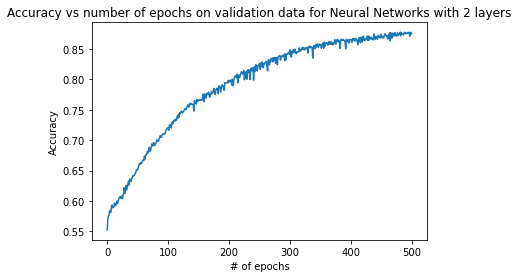

In [25]:
plt.plot(accuracy)
plt.xlabel('# of epochs')
plt.ylabel("Accuracy")
plt.title('Accuracy vs number of epochs on validation data for Neural Networks with 2 layers')

In [26]:
net_2 = Neural_Network([X_vector_train.shape[1], 200, 2])
net_2.SGD(training_data, 300, 200, 0.5, test_data=valid_data)

Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete
Epoch 11 complete
Epoch 12 complete
Epoch 13 complete
Epoch 14 complete
Epoch 15 complete
Epoch 16 complete
Epoch 17 complete
Epoch 18 complete
Epoch 19 complete
Epoch 20 complete
Epoch 21 complete
Epoch 22 complete
Epoch 23 complete
Epoch 24 complete
Epoch 25 complete
Epoch 26 complete
Epoch 27 complete
Epoch 28 complete
Epoch 29 complete
Epoch 30 complete
Epoch 31 complete
Epoch 32 complete
Epoch 33 complete
Epoch 34 complete
Epoch 35 complete
Epoch 36 complete
Epoch 37 complete
Epoch 38 complete
Epoch 39 complete
Epoch 40 complete
Epoch 41 complete
Epoch 42 complete
Epoch 43 complete
Epoch 44 complete
Epoch 45 complete
Epoch 46 complete
Epoch 47 complete
Epoch 48 complete
Epoch 49 complete
Epoch 50 complete
Epoch 51 complete
Epoch 52 complete
Epoch 53 complete
Epoch 54 complete
Epoch 55 complete
Ep

In [27]:
accuracy_2layer = net_2.accuracy_mat
accuracy_2layer

[]

Text(0.5, 1.0, 'Accuracy vs number of epochs on validation data for Neural Networks with 1 layer')

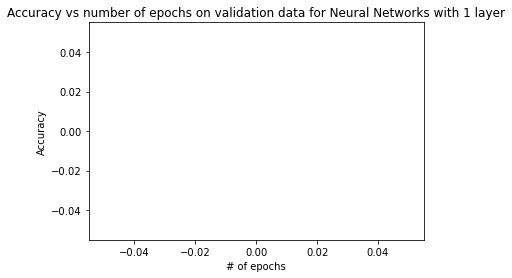

In [28]:
plt.plot(accuracy_2layer)
plt.xlabel('# of epochs')
plt.ylabel("Accuracy")
plt.title('Accuracy vs number of epochs on validation data for Neural Networks with 1 layer')

<h3> prediction on test data </h3>

In [29]:
df_test = pd.read_csv(r'C:\Users\Bhavesh Kilaru\Desktop\ML\project2\code and files\data files\twitter_validation.csv')
df_test.columns = ['id', 'topic', 'polarity', 'tweet']
df_test = df_test.loc[df_test['polarity'].isin(['Positive','Negative'])]
df_test = df_test.dropna()
df_test = df_test.loc[df_test['topic'].isin(['Amazon', 'Facebook', 'Xbox(Xseries)','Nvidia','Google','Microsoft', 'FIFA', 'HomeDepot'])]#.groupby('topic').count()
df_test.shape

(120, 4)

<body> label encoding for test data labels.</body>

In [30]:
new_col = []
for t in df_test['tweet']:
    new_col.append(process_tweet(t))
    
df_test['unique_words'] = new_col

temp = [] 
for i in df_test['polarity']:
    if i == 'Positive':
        temp.append(1)
    else:
        temp.append(0)

        
df_test['Sentiment'] = temp
df_test

,id,topic,polarity,tweet,unique_words,Sentiment
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,pay WORD functions poorly Chromebook,0
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,Hi Ive Madeleine McCann cellar past years litt...,0
14,9135,Nvidia,Positive,Congrats to the NVIDIA NeMo team for the 1.0.0...,Congrats NeMo team release candidate Really ex...,1
18,8056,Microsoft,Negative,What does that say about Microsoft hardware & ...,say hardware software security Man gets hacked,0
29,8857,Nvidia,Positive,Watching NVIDIA position itself as not just a ...,Watching position leading hardware manufacture...,1
...,...,...,...,...,...,...
970,8318,Microsoft,Negative,Why didn’t anyone think of this acronym for BL...,didnt anyone think acronym BLM Batteries Lives...,0
973,397,Amazon,Positive,#Amazon Best Seller!\n\nScreen Cleaner Kit - B...,Amazon Best Seller Screen Cleaner Kit Best LED...,1
988,5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...,Thank Matching funds Home Depot RW payment gen...,1
992,314,Amazon,Negative,Please explain how this is possible! How can t...,Please explain possible let companies overchar...,0


<body> removing the words that occured less than once in test data.</body>

In [31]:
df_test["unique_words"] = df_test["unique_words"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
X_test_df = df_test['unique_words']
y_test_df = df_test['Sentiment']

<body>converting the entire train data and validation data into numerical features and transforming the test data into numerical features.</body>

In [32]:
vectorizer_test = TfidfVectorizer(min_df = 7)
Final_Data = vectorizer_test.fit_transform(X)
X_vector_test= vectorizer_test.transform(X_test_df)
x_train = Final_Data.toarray()
x_test = X_vector_test.toarray()

x_train_df_new = np.insert(x_train, 0, 1, axis = 1)
x_test_df_new = np.insert(x_test, 0, 1, axis = 1)

x_train = x_train_df_new
x_test  = x_test_df_new

y_train = pd.Series(y).array
y_test = pd.Series(y_test_df).array

<body> training the perceptron on entire train and validation data, then checking its accuracy on test data.</body>

In [35]:
final_perceptron  = np.zeros((x_train.shape[1], 1))
final_perceptron = perceptron(x_train, y_train, final_perceptron, 0.1,30)

pred_test_y = []
for i in range(len(x_test)):
    val = np.dot(x_test[i], final_perceptron)

    if val > 0:
        pred_test_y.append(1)
    else:
        pred_test_y.append(0)
        
p_s = accuracy_score(y_test, pred_test_y)
C_m = confusion_matrix(y_test,pred_test_y)
print(f"the accuracy score for eta = 0.1 and n = 30 is {p_s}")
print(f"the confusion matrix for eta = 0.1 and n = 30 is {C_m}")

the accuracy score for eta = 0.1 and n = 30 is 0.9166666666666666
the confusion matrix for eta = 0.1 and n = 30 is [[65  0]
 [10 45]]


<body> training the logistic regression model on entire train and validation data, then checking its accuracy on test data.</body>

In [36]:
final_theta, cost_epochs = logistic_regression(x_train, y_train, 10000, alpha = 0.1)

After 10 epochs, Loss = 0.7123941009823659
After 20 epochs, Loss = 0.7017669381789405
After 30 epochs, Loss = 0.6934044239551864
After 40 epochs, Loss = 0.6863446656848504
After 50 epochs, Loss = 0.6800517192355431
After 60 epochs, Loss = 0.6742306598713823
After 70 epochs, Loss = 0.6687180759861779
After 80 epochs, Loss = 0.6634221230645051
After 90 epochs, Loss = 0.6582904798616883
After 100 epochs, Loss = 0.6532930603637929
After 110 epochs, Loss = 0.6484122535472623
After 120 epochs, Loss = 0.6436377651132192
After 130 epochs, Loss = 0.6389633404366314
After 140 epochs, Loss = 0.634385119385512
After 150 epochs, Loss = 0.6299007691262519
After 160 epochs, Loss = 0.6255085086114144
After 170 epochs, Loss = 0.6212067890276658
After 180 epochs, Loss = 0.6169943648587661
After 190 epochs, Loss = 0.6128700905646912
After 200 epochs, Loss = 0.6088326420135717
After 210 epochs, Loss = 0.6048806322186883
After 220 epochs, Loss = 0.6010126659468128
After 230 epochs, Loss = 0.597227313646540

After 1850 epochs, Loss = 0.3899435702829643
After 1860 epochs, Loss = 0.3894724780734383
After 1870 epochs, Loss = 0.38900448605381366
After 1880 epochs, Loss = 0.38853955800407625
After 1890 epochs, Loss = 0.38807766006001965
After 1900 epochs, Loss = 0.38761876921989796
After 1910 epochs, Loss = 0.38716283865585277
After 1920 epochs, Loss = 0.38670983499323364
After 1930 epochs, Loss = 0.38625972542260156
After 1940 epochs, Loss = 0.38581248780967053
After 1950 epochs, Loss = 0.38536813470726383
After 1960 epochs, Loss = 0.3849266017144179
After 1970 epochs, Loss = 0.38448783686707383
After 1980 epochs, Loss = 0.38405180999628125
After 1990 epochs, Loss = 0.383618491427959
After 2000 epochs, Loss = 0.3831878519714093
After 2010 epochs, Loss = 0.382759871200485
After 2020 epochs, Loss = 0.38233452995962625
After 2030 epochs, Loss = 0.38191180317471307
After 2040 epochs, Loss = 0.3814916608270477
After 2050 epochs, Loss = 0.38107406439321095
After 2060 epochs, Loss = 0.380658993258545

After 3660 epochs, Loss = 0.33532804634594143
After 3670 epochs, Loss = 0.33513187735456434
After 3680 epochs, Loss = 0.3349364341987561
After 3690 epochs, Loss = 0.334741712606038
After 3700 epochs, Loss = 0.33454770833903025
After 3710 epochs, Loss = 0.3343544171950821
After 3720 epochs, Loss = 0.33416183500590696
After 3730 epochs, Loss = 0.3339699576372207
After 3740 epochs, Loss = 0.33377878098838604
After 3750 epochs, Loss = 0.33358830099206194
After 3760 epochs, Loss = 0.33339851361385353
After 3770 epochs, Loss = 0.33320941499207063
After 3780 epochs, Loss = 0.33302100834890797
After 3790 epochs, Loss = 0.332833282405771
After 3800 epochs, Loss = 0.3326462332563125
After 3810 epochs, Loss = 0.33245985702572745
After 3820 epochs, Loss = 0.3322741498701727
After 3830 epochs, Loss = 0.3320891079764453
After 3840 epochs, Loss = 0.3319047429278997
After 3850 epochs, Loss = 0.3317210459421127
After 3860 epochs, Loss = 0.33153800793165766
After 3870 epochs, Loss = 0.33135562727379114


After 5470 epochs, Loss = 0.3086225612790181
After 5480 epochs, Loss = 0.3085115597892816
After 5490 epochs, Loss = 0.30840085894156044
After 5500 epochs, Loss = 0.30829045403315697
After 5510 epochs, Loss = 0.3081803438355347
After 5520 epochs, Loss = 0.30807052712722677
After 5530 epochs, Loss = 0.3079610026937796
After 5540 epochs, Loss = 0.3078517693277006
After 5550 epochs, Loss = 0.3077428258284053
After 5560 epochs, Loss = 0.3076341710021663
After 5570 epochs, Loss = 0.3075258036620615
After 5580 epochs, Loss = 0.30741772262792333
After 5590 epochs, Loss = 0.3073099267262891
After 5600 epochs, Loss = 0.3072024147903499
After 5610 epochs, Loss = 0.3070951856599022
After 5620 epochs, Loss = 0.30698823818129933
After 5630 epochs, Loss = 0.3068815712074036
After 5640 epochs, Loss = 0.3067751835975363
After 5650 epochs, Loss = 0.30666907421743317
After 5660 epochs, Loss = 0.30656324193919476
After 5670 epochs, Loss = 0.3064576856412428
After 5680 epochs, Loss = 0.3063524042082722
Aft

After 7280 epochs, Loss = 0.292423611661909
After 7290 epochs, Loss = 0.2923515590058234
After 7300 epochs, Loss = 0.2922796593388962
After 7310 epochs, Loss = 0.29220791216496994
After 7320 epochs, Loss = 0.29213631699007864
After 7330 epochs, Loss = 0.29206487332243536
After 7340 epochs, Loss = 0.2919935806724193
After 7350 epochs, Loss = 0.29192243855256406
After 7360 epochs, Loss = 0.2918514464775456
After 7370 epochs, Loss = 0.291780603964169
After 7380 epochs, Loss = 0.29170991053135864
After 7390 epochs, Loss = 0.2916393657001438
After 7400 epochs, Loss = 0.291568968993649
After 7410 epochs, Loss = 0.29149871993708076
After 7420 epochs, Loss = 0.2914286180577166
After 7430 epochs, Loss = 0.29135866288489337
After 7440 epochs, Loss = 0.29128885665447535
After 7450 epochs, Loss = 0.2912191997425166
After 7460 epochs, Loss = 0.29114968813742403
After 7470 epochs, Loss = 0.2910803213766496
After 7480 epochs, Loss = 0.29101109899964905
After 7490 epochs, Loss = 0.2909420205478692
Aft

After 9090 epochs, Loss = 0.28148102144652426
After 9100 epochs, Loss = 0.2814303888939788
After 9110 epochs, Loss = 0.28137984600823707
After 9120 epochs, Loss = 0.2813293925483958
After 9130 epochs, Loss = 0.28127902827441886
After 9140 epochs, Loss = 0.2812287529471329
After 9150 epochs, Loss = 0.2811785663282239
After 9160 epochs, Loss = 0.2811284681802325
After 9170 epochs, Loss = 0.2810784582665501
After 9180 epochs, Loss = 0.2810285363514161
After 9190 epochs, Loss = 0.2809787021999141
After 9200 epochs, Loss = 0.2809289555779667
After 9210 epochs, Loss = 0.2808792962523325
After 9220 epochs, Loss = 0.28082972399060274
After 9230 epochs, Loss = 0.28078023856119677
After 9240 epochs, Loss = 0.28073083973335994
After 9250 epochs, Loss = 0.28068152727715767
After 9260 epochs, Loss = 0.2806323009634732
After 9270 epochs, Loss = 0.28058316056400345
After 9280 epochs, Loss = 0.28053410585125627
After 9290 epochs, Loss = 0.2804851365985451
After 9300 epochs, Loss = 0.2804362525799875
A

In [37]:
preds_prob = calc_h(x_test, final_theta)
y_pred = preds_prob.round()
print("The accuracy of the given model on test data for logistic regression is ",accuracy_score(y_test,y_pred))

The accuracy of the given model on test data for logistic regression is  0.975


In [38]:
C_m_log = confusion_matrix(y_test,y_pred)
print("The confusion matrix of the given model on test data for logistic regression is ",C_m_log)

The confusion matrix of the given model on test data for logistic regression is  [[64  1]
 [ 2 53]]


<h5> predicting via the neural network </h5>

In [39]:
X_vector_test= vectorizer.transform(X_test_df)
x_test_df_new = [np.reshape(x, (X_vector_test.shape[1], 1)) for x in X_vector_test.toarray()]
y_test = y_test_df.array
test_data = zip(x_test_df_new, y_test)

pred = net.predict(test_data)
#pred= pred.round()
print("The accuracy score of neural networks with 2layers on test data is ",accuracy_score(y_test, pred))

The accuracy score of neural networks with 2layers on test data is  0.975


In [40]:
confusion_matrix(y_test,pred)

array([[65,  0],
       [ 3, 52]], dtype=int64)